# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
import feather

In [4]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [5]:
PATH = "../data/bulldozers/"

df_raw = feather.read_dataframe('../data/tmp/bulldozers-raw')

In [54]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [55]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [56]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [57]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [58]:
raw_train.shape, raw_valid.shape

((389125, 65), (12000, 65))

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [12]:
set_rf_samples(50000)

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2063620907510584, 0.2509048841305007, 0.9112118087895893, 0.8795617496982697, 0.8940864616006721]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [14]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.31 s, sys: 99.9 ms, total: 1.41 s
Wall time: 1.41 s


(10.343022052150298, 0.16561560621353077)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [13]:
??parallel_trees

In [15]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 69.5 ms, sys: 60.3 ms, total: 130 ms
Wall time: 576 ms


(10.343022052150298, 0.16561560621353077)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

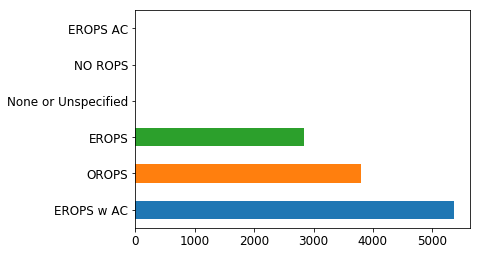

In [16]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [17]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.888158,9.870741,0.284581
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.614880,10.546115,0.265877
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.788210,9.776530,0.227458


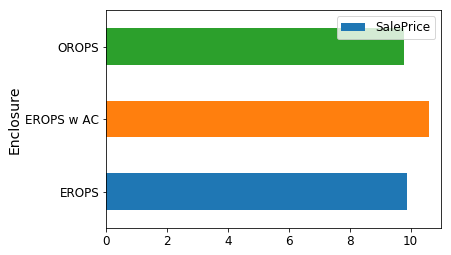

In [18]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

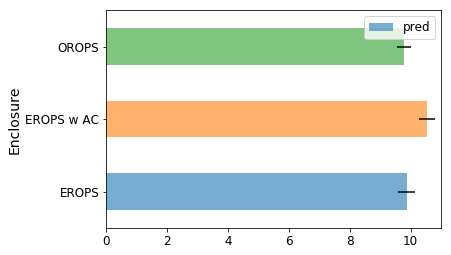

In [19]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

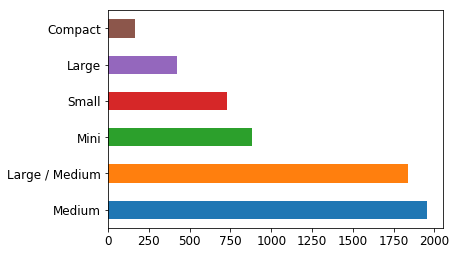

In [20]:
raw_valid.ProductSize.value_counts().plot.barh();

In [21]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.670200,9.723517,0.308869
Large,10.491001,10.380279,0.381605
Large / Medium,10.698794,10.644421,0.293988
Medium,10.704027,10.636939,0.291781
Mini,9.619849,9.628534,0.262295
Small,10.376032,10.322242,0.298836


In [22]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036762
Compact           0.031765
Small             0.028951
Large / Medium    0.027619
Medium            0.027431
Mini              0.027241
dtype: float64

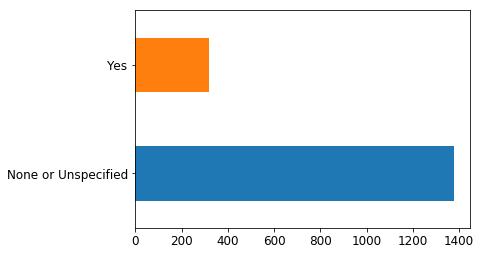

In [23]:
raw_valid.Coupler_System.value_counts().plot.barh()

In [24]:
flds = ['Coupler_System', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
Coupler_System,,,
None or Unspecified,9.299773,9.264544,0.204355
Yes,9.304194,9.296403,0.197894


In [25]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

Coupler_System
None or Unspecified    0.022058
Yes                    0.021287
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [33]:
??rf_feat_importance

In [26]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.177608
37,Coupler_System,0.102247
13,ProductSize,0.099273
14,fiProductClassDesc,0.080863
38,Grouser_Tracks,0.058055
2,ModelID,0.056163
63,saleElapsed,0.049642
39,Hydraulics_Flow,0.043365
10,fiSecondaryDesc,0.038151
19,Enclosure,0.035997


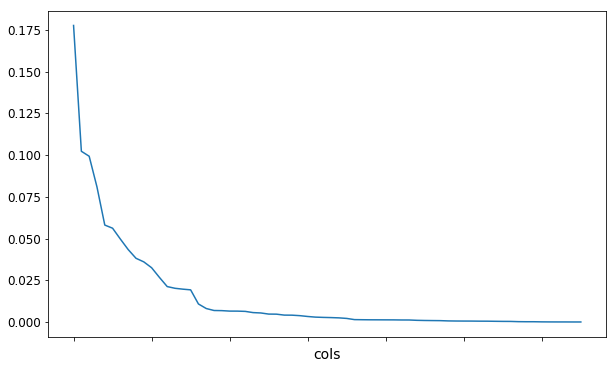

In [27]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [28]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

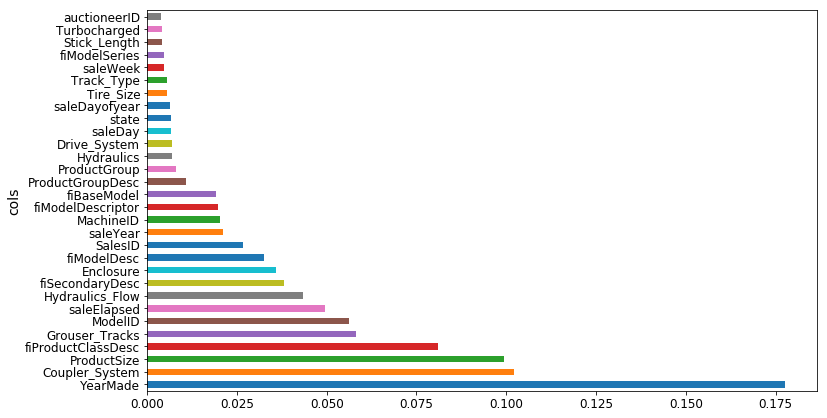

In [29]:
plot_fi(fi[:30]);

In [30]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [31]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [32]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2066433145392434, 0.2500524967225342, 0.9109696483703761, 0.8803786781312428, 0.8947289616988193]


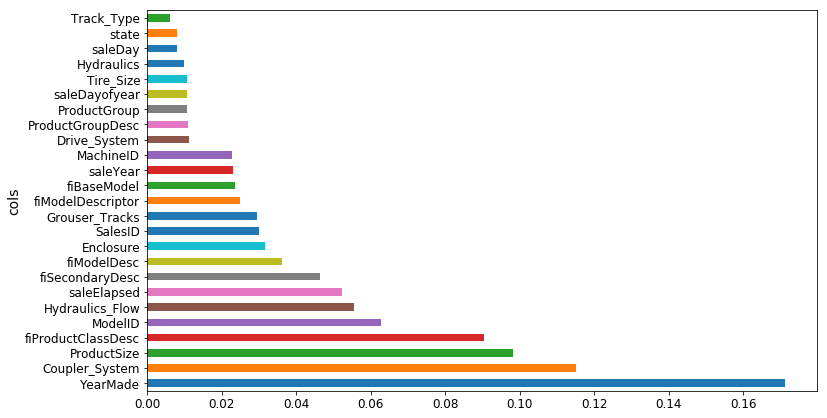

In [33]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### After YearMade fixing

In [65]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [66]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2076499437344317, 0.2481891743088558, 0.9101001420197266, 0.8821548061372293, 0.8937931687938188]


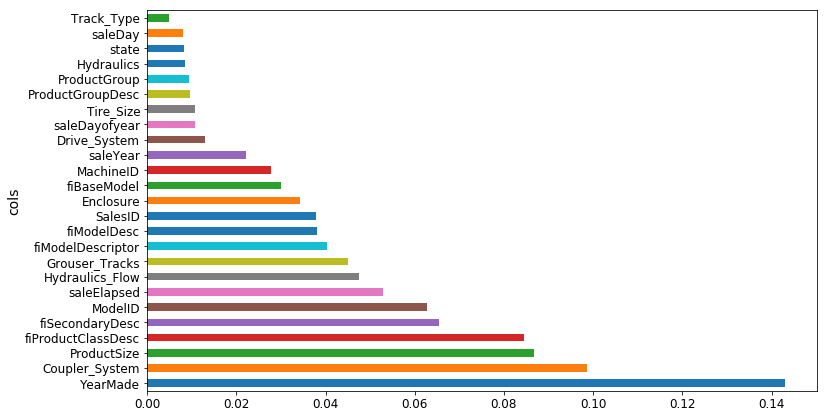

In [67]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

### Without Coupler System

In [107]:
to_drop = ['Coupler_System']

In [108]:
df_keep = df_trn[to_keep].drop(columns=to_drop).copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [111]:
reset_rf_samples()

In [113]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14973735974545063, 0.23433882229256275, 0.9532527882487002, 0.8949406540633692, 0.90812963502394]


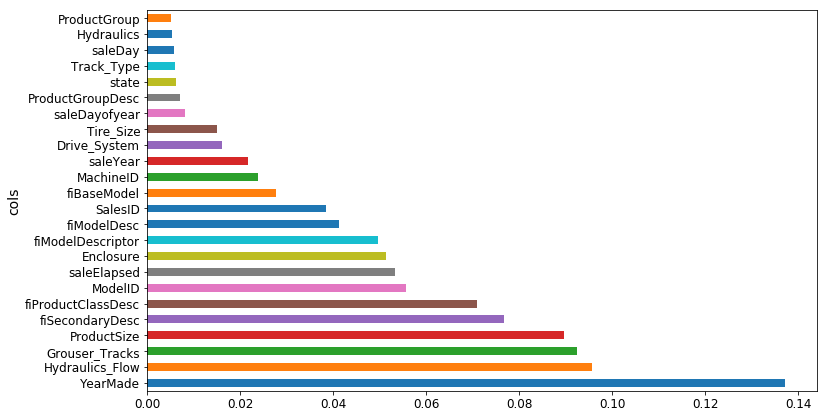

In [114]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## Some EDA attempts

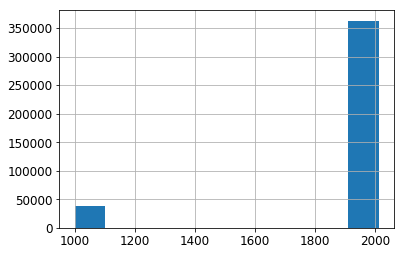

In [34]:
df_raw.YearMade.hist()

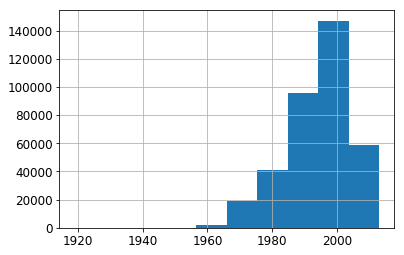

In [35]:
df_raw[df_raw.YearMade > 1200].YearMade.hist()

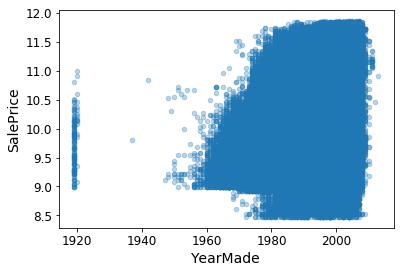

In [36]:
df_raw[df_raw.YearMade > 1200].plot('YearMade', 'SalePrice', 'scatter', alpha=0.3);

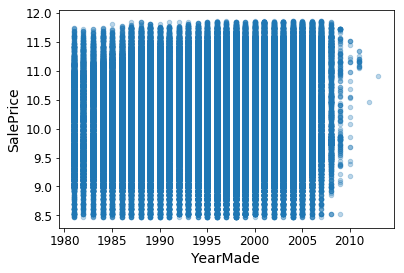

In [37]:
df_raw[df_raw.YearMade > 1980].plot('YearMade', 'SalePrice', 'scatter', alpha=0.3);

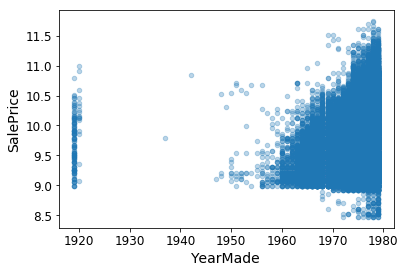

In [38]:
df_raw[(df_raw.YearMade < 1980) & (df_raw.YearMade > 1910)
      ].plot('YearMade', 'SalePrice', 'scatter', alpha=0.3);

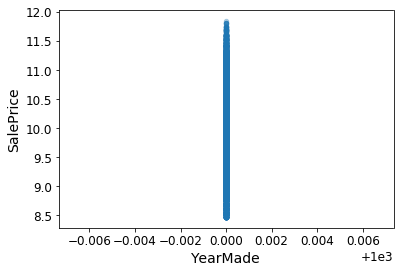

In [39]:
df_raw[(df_raw.YearMade < 1910)].plot('YearMade', 'SalePrice', 'scatter', alpha=0.3);

In [59]:
ym_median = int(X_train[(X_train.YearMade > 1980)].YearMade.median())

In [60]:
ym_median

1997

In [61]:
# change weird encoding (year made == 1000) to median year, because scatter for 1000 looks like scatter after 80's
df_trn.loc[(df_trn.YearMade == 1000), 'YearMade'] = ym_median

In [62]:
df_trn.loc[(df_trn.YearMade > 1000) & (df_trn.YearMade < 1921), 'YearMade'] = ym_median

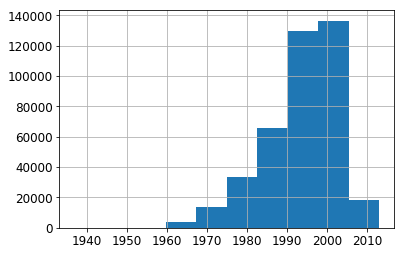

In [63]:
df_trn.YearMade.hist();

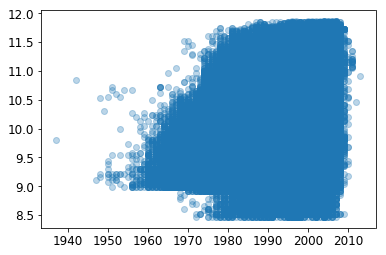

In [64]:
plt.scatter(df_trn.YearMade, y_trn, alpha=0.3);

### Coupler System EDA

In [101]:
df_raw.Hydraulics_Flow.cat.categories

Index(['High Flow', 'None or Unspecified', 'Standard'], dtype='object')

In [102]:
df_raw.Hydraulics_Flow.value_counts()

Standard               42784
High Flow                553
None or Unspecified       25
Name: Hydraulics_Flow, dtype: int64

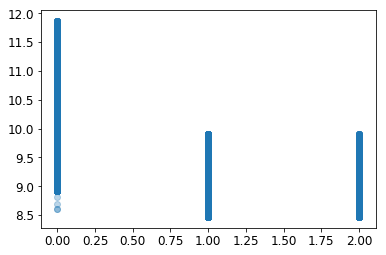

In [70]:
plt.scatter(df_trn.Coupler_System, y_trn, alpha=0.3);

In [88]:
coupl_sys_na = df_trn[df_trn.Coupler_System == 0].copy()

In [90]:
for col in coupl_sys_na.columns:
    if coupl_sys_na[col].nunique() < 2:
        print(col, coupl_sys_na[col].unique())

Coupler_System [0]
Grouser_Tracks [0]
Hydraulics_Flow [0]
saleIs_year_start [False]


In [117]:
df_raw.ProductSize.cat.categories

Index(['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small'], dtype='object')

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2132925755978791, 0.25212838463780185, 0.90966193351324276, 0.88647501408921581, 0.89194147155121262]


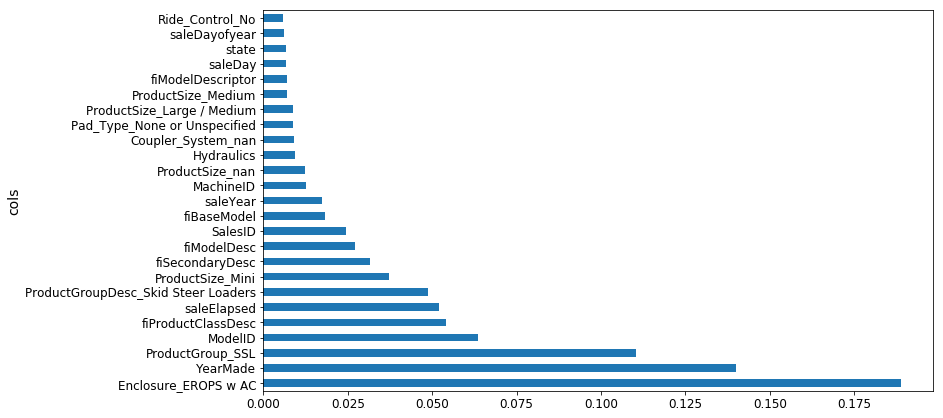

In [ ]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [ ]:
from scipy.cluster import hierarchy as hc

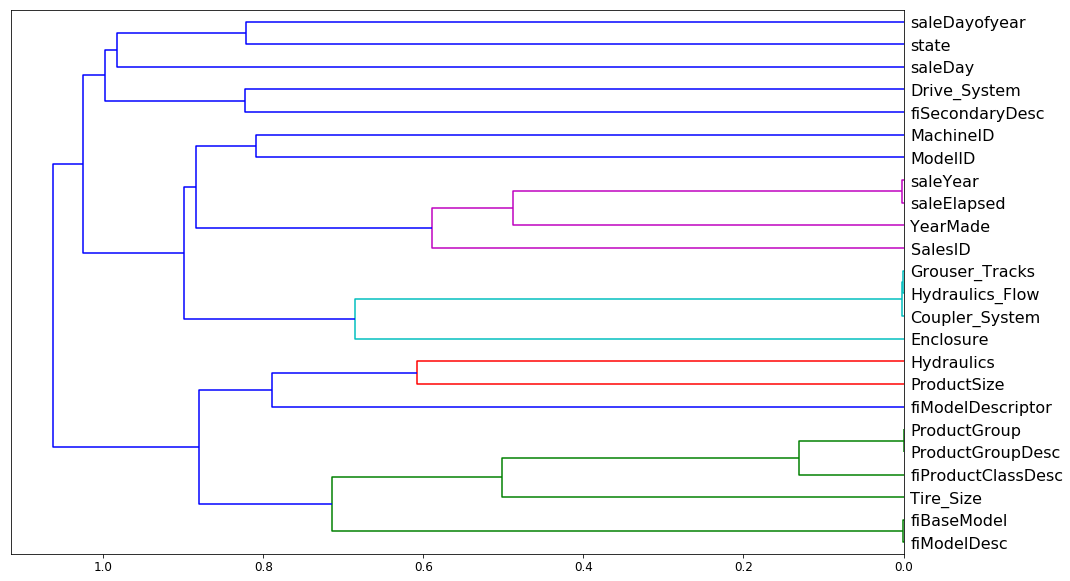

In [ ]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [ ]:
get_oob(df_keep)

0.88999425494301454

Now we try removing each variable one at a time.

In [ ]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.889037446375
saleElapsed 0.886210803445
fiModelDesc 0.888540591321
fiBaseModel 0.88893958239
Grouser_Tracks 0.890385236272
Coupler_System 0.889601052658


It looks like we can try one from each group for removal. Let's see what that does.

In [ ]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88858458047200739

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [ ]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [ ]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12615142089579687, 0.22781819082173235, 0.96677727309424211, 0.90731173105384466, 0.9084359846323049]


# Partial dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

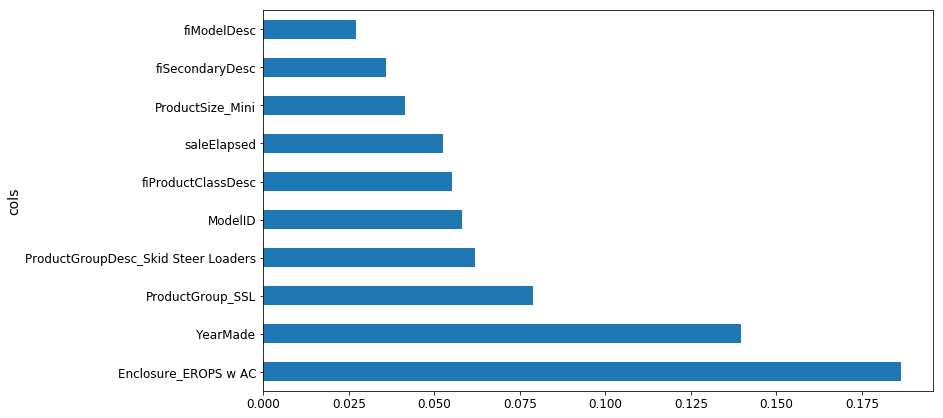

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

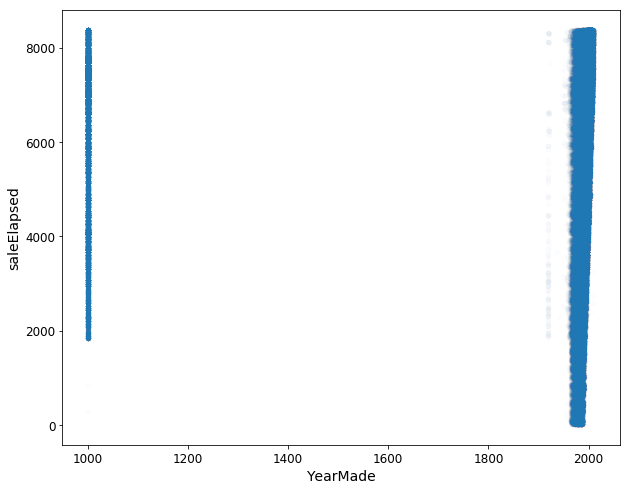

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

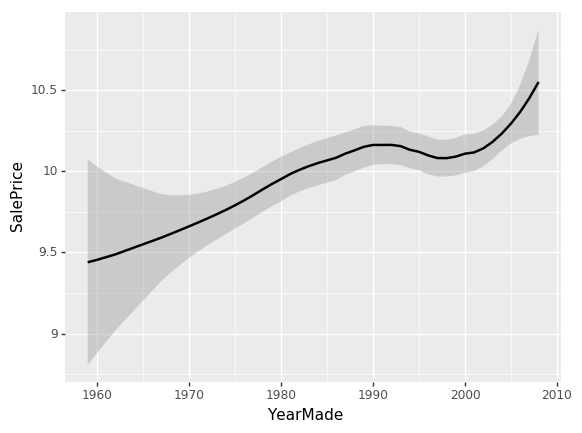

<ggplot: (8729550331912)>

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

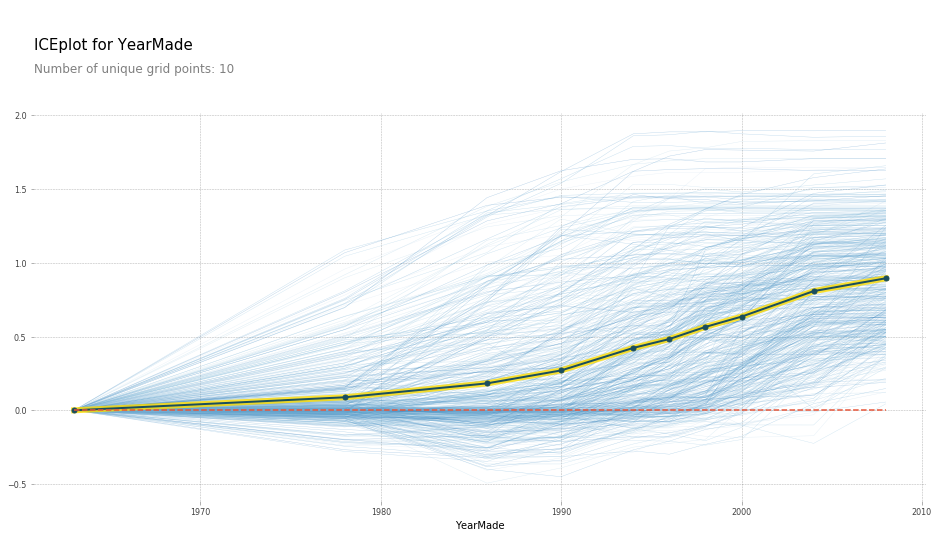

In [ ]:
plot_pdp('YearMade')

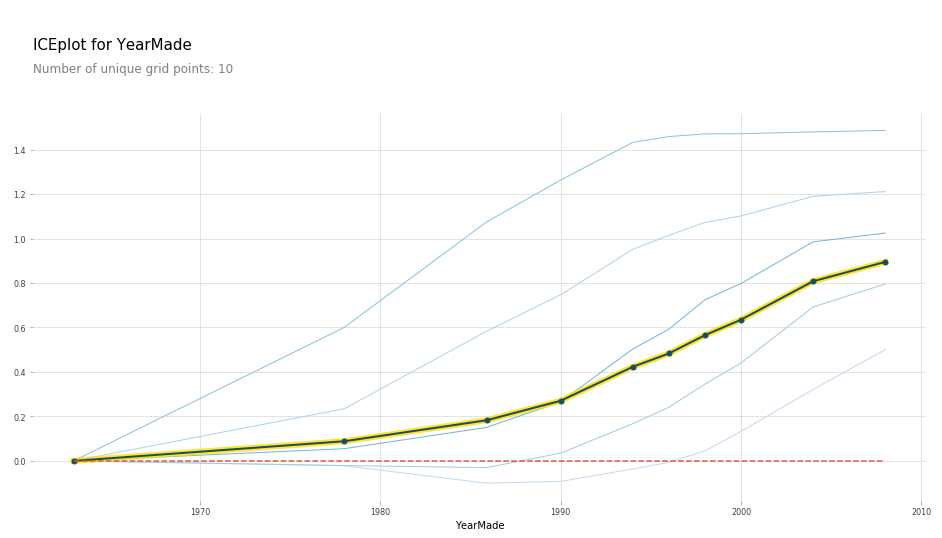

In [ ]:
plot_pdp('YearMade', clusters=5)

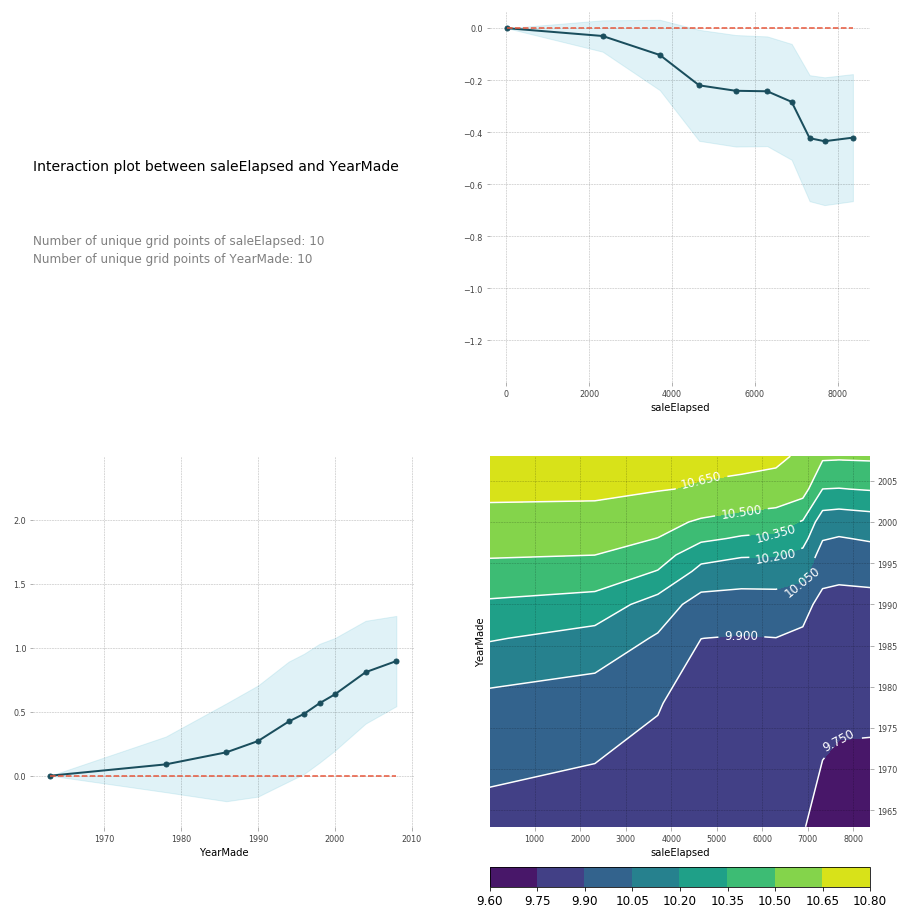

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

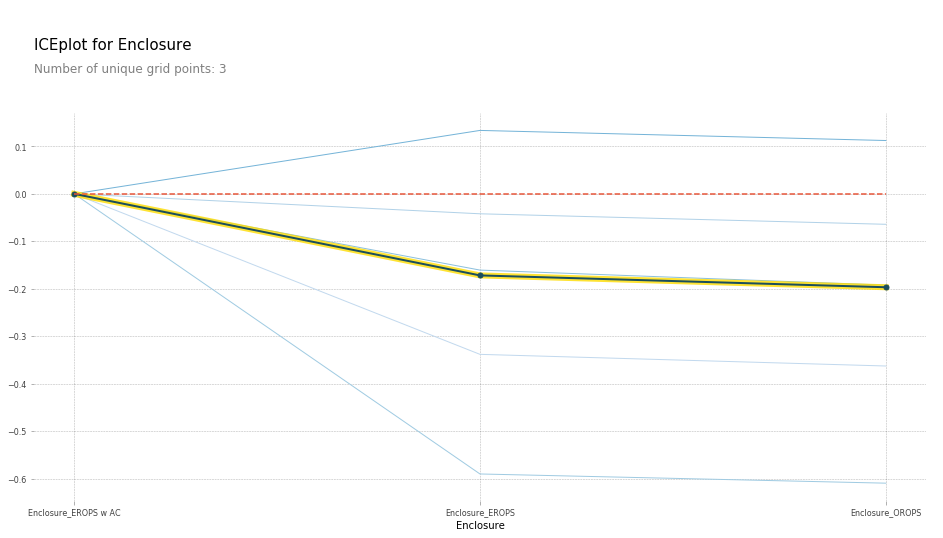

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

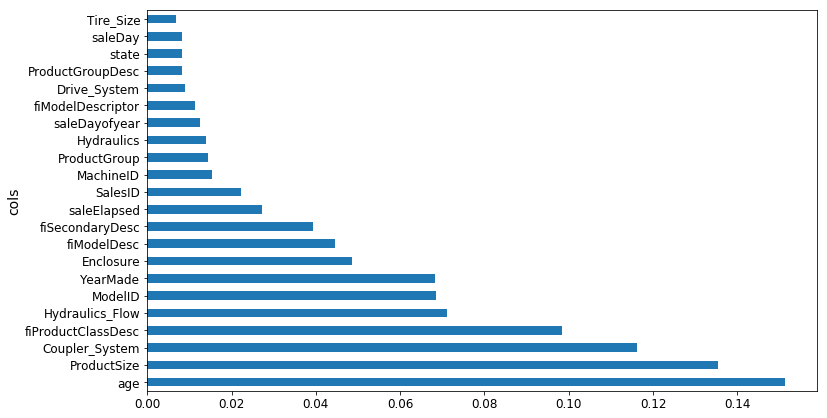

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


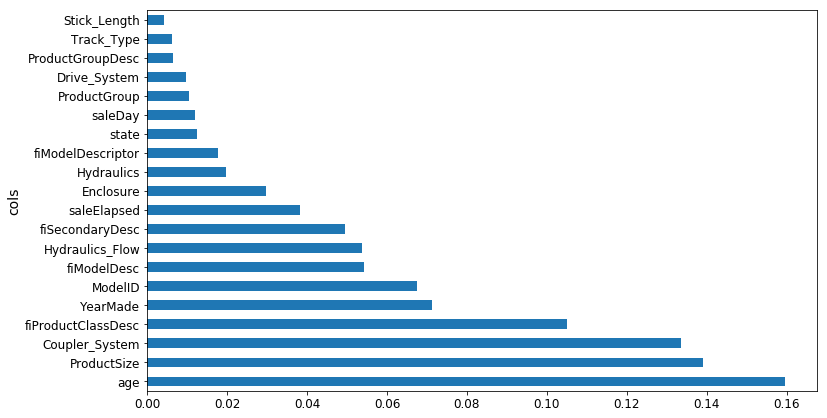

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
